In [1]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("atalaydenknalbant/rawg-games-dataset")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
df = ds["train"].to_pandas()

In [30]:
df.head()

id                         slug                     name    released  \
0  19103       half-life-2-lost-coast  Half-Life 2: Lost Coast  2005-10-27   
1  12020                left-4-dead-2            Left 4 Dead 2  2009-11-17   
2  13536                       portal                   Portal  2007-10-09   
3   3272                rocket-league            Rocket League  2015-07-07   
4   3439  life-is-strange-episode-1-2          Life is Strange  2015-01-29   

                                    background_image  rating  rating_top  \
0  https://media.rawg.io/media/games/b7b/b7b83817...    3.45         4.0   
1  https://media.rawg.io/media/games/d58/d588947d...    4.09         4.0   
2  https://media.rawg.io/media/games/7fa/7fa0b586...    4.49         5.0   
3  https://media.rawg.io/media/games/8cc/8cce7c0e...    3.93         4.0   
4  https://media.rawg.io/media/games/562/56255381...    4.12         5.0   

   ratings_count  reviews_text_count    added  ...  achievements_count  \
0         1164.0                 3.0  11676.0  ...                 NaN   
1         3355.0                25.0  17398.0  ...               166.0   
2         4896.0                44.0  17582.0  ...                15.0   
3         2827.0                22.0  12787.0  ...               430.0   
4         3717.0                47.0  15788.0  ...               607.0   

                     alternative_names parent_achievements_count  \
0                                  nan                       NaN   
1                                 L4D2                     102.0   
2                              ポータル|포털                      15.0   
3                                  nan                      94.0   
4  LiS|Life is Strange Complete Season                      61.0   

   game_series_count additions_count movies_count reddit_name  \
0                NaN             NaN          NaN         nan   
1                2.0             NaN          NaN         nan   
2                3.0             4.0          NaN         nan   
3                1.0             3.0          NaN         nan   
4                5.0             6.0          NaN         nan   

  reddit_description reddit_logo tba  
0                nan         nan NaN  
1                nan         nan NaN  
2                nan         nan NaN  
3                nan         nan NaN  
4                nan         nan NaN  

[5 rows x 54 columns]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889793 entries, 0 to 889792
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           889793 non-null  int64  
 1   slug                         889793 non-null  object 
 2   name                         889793 non-null  object 
 3   released                     889793 non-null  object 
 4   background_image             889793 non-null  object 
 5   rating                       18109 non-null   float64
 6   rating_top                   20078 non-null   float64
 7   ratings_count                57839 non-null   float64
 8   reviews_text_count           9471 non-null    float64
 9   added                        109395 non-null  float64
 10  playtime                     33286 non-null   float64
 11  suggestions_count            850510 non-null  float64
 12  updated                      889793 non-null  object 
 13 

In [32]:
df.isnull().sum().sort_values(ascending=False)

clip                           889793
additions_count                888022
reddit_count                   887958
tba                            887125
parents_count                  886502
metacritic                     882663
reviews_text_count             880322
twitch_count                   879943
game_series_count              879144
youtube_count                  878588
movies_count                   876901
creators_count                 874569
rating                         871684
rating_top                     869715
parent_achievements_count      861092
achievements_count             861069
playtime                       856507
ratings_count                  831954
reviews_count                  830532
added                          780398
suggestions_count               39283
screenshots_count               27978
website                             0
alternative_names                   0
reddit_description                  0
description_raw                     0
description 

In [33]:
df.replace(['NaN', 'nan', 'None'], np.nan, inplace=True)

In [34]:
df = df[["name","rating","metacritic","ratings_count","reviews_count","added","playtime","suggestions_count","achievements_count","movies_count","twitch_count","youtube_count","reddit_count","game_series_count","genres","parent_platforms","tags","esrb_rating",'background_image','released']]

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889793 entries, 0 to 889792
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   name                889791 non-null  object 
 1   rating              18109 non-null   float64
 2   metacritic          7130 non-null    float64
 3   ratings_count       57839 non-null   float64
 4   reviews_count       59261 non-null   float64
 5   added               109395 non-null  float64
 6   playtime            33286 non-null   float64
 7   suggestions_count   850510 non-null  float64
 8   achievements_count  28724 non-null   float64
 9   movies_count        12892 non-null   float64
 10  twitch_count        9850 non-null    float64
 11  youtube_count       11205 non-null   float64
 12  reddit_count        1835 non-null    float64
 13  game_series_count   10649 non-null   float64
 14  genres              889793 non-null  object 
 15  parent_platforms    889793 non-nul

In [36]:
df.isnull().sum().sort_values(ascending=False)

reddit_count          887958
metacritic            882663
twitch_count          879943
game_series_count     879144
youtube_count         878588
movies_count          876901
rating                871684
achievements_count    861069
playtime              856507
ratings_count         831954
reviews_count         830532
esrb_rating           819125
added                 780398
suggestions_count      39283
released               29457
background_image       27394
name                       2
tags                       1
parent_platforms           0
genres                     0
dtype: int64

In [37]:
df.dropna(subset=['name', 'genres', 'rating'], axis=0, inplace=True)

In [38]:
df.isnull().sum().sort_values(ascending=False)

reddit_count          16688
movies_count          15550
game_series_count     12743
metacritic            12294
esrb_rating           10586
twitch_count           9740
youtube_count          8917
achievements_count     8217
playtime               5755
released                389
suggestions_count        96
background_image         82
ratings_count             1
rating                    0
added                     0
reviews_count             0
genres                    0
parent_platforms          0
tags                      0
name                      0
dtype: int64

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18012 entries, 0 to 97414
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                18012 non-null  object 
 1   rating              18012 non-null  float64
 2   metacritic          5808 non-null   float64
 3   ratings_count       18012 non-null  float64
 4   reviews_count       18012 non-null  float64
 5   added               18012 non-null  float64
 6   playtime            12334 non-null  float64
 7   suggestions_count   18012 non-null  float64
 8   achievements_count  9861 non-null   float64
 9   movies_count        2559 non-null   float64
 10  twitch_count        8360 non-null   float64
 11  youtube_count       9174 non-null   float64
 12  reddit_count        1418 non-null   float64
 13  game_series_count   5356 non-null   float64
 14  genres              18012 non-null  object 
 15  parent_platforms    18012 non-null  object 
 16  tags     

In [41]:
df.isnull().sum().sort_values(ascending=False)

reddit_count          16594
movies_count          15453
game_series_count     12656
metacritic            12204
esrb_rating           10528
twitch_count           9652
youtube_count          8838
achievements_count     8151
playtime               5678
released                381
background_image         20
rating                    0
suggestions_count         0
added                     0
reviews_count             0
genres                    0
parent_platforms          0
tags                      0
ratings_count             0
name                      0
dtype: int64

In [42]:
df = df.drop(columns=['metacritic','movies_count','twitch_count','youtube_count','reddit_count','game_series_count','esrb_rating','achievements_count','tags'])

In [43]:
df.dropna(subset=['suggestions_count','ratings_count','released', 'background_image'], axis=0, inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17611 entries, 0 to 65527
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               17611 non-null  object 
 1   rating             17611 non-null  float64
 2   ratings_count      17611 non-null  float64
 3   reviews_count      17611 non-null  float64
 4   added              17611 non-null  float64
 5   playtime           12037 non-null  float64
 6   suggestions_count  17611 non-null  float64
 7   genres             17611 non-null  object 
 8   parent_platforms   17611 non-null  object 
 9   background_image   17611 non-null  object 
 10  released           17611 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.6+ MB


In [45]:
df.isnull().sum().sort_values(ascending=False)

playtime             5574
name                    0
rating                  0
ratings_count           0
reviews_count           0
added                   0
suggestions_count       0
genres                  0
parent_platforms        0
background_image        0
released                0
dtype: int64

In [46]:
df = df[df["playtime"].notnull()]

In [47]:
# Save the cleaned dataframe to a new CSV
df.to_csv("game_recommendation_cleaned.csv", index=False)

In [48]:
df.isnull().sum().sort_values(ascending=False)

name                 0
rating               0
ratings_count        0
reviews_count        0
added                0
playtime             0
suggestions_count    0
genres               0
parent_platforms     0
background_image     0
released             0
dtype: int64

In [49]:
df.describe()

rating  ratings_count  reviews_count         added      playtime  \
count  12037.000000   12037.000000   12037.000000  12037.000000  12037.000000   
mean       3.218844     122.471795     123.958711    907.556617      4.878458   
std        0.751316     343.436306     347.478730   1622.514391     20.346094   
min        1.000000       4.000000       6.000000     10.000000      1.000000   
25%        2.710000      11.000000      11.000000    164.000000      1.000000   
50%        3.330000      24.000000      25.000000    359.000000      3.000000   
75%        3.810000      77.000000      78.000000    900.000000      4.000000   
max        5.000000    7153.000000    7268.000000  22126.000000   1473.000000   

       suggestions_count  
count       12037.000000  
mean          373.162416  
std           176.387015  
min             2.000000  
25%           241.000000  
50%           369.000000  
75%           498.000000  
max          1729.000000

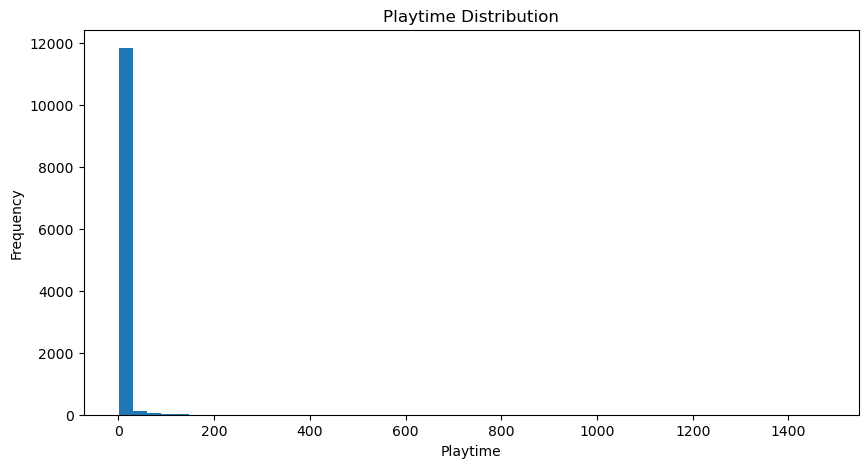

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df["playtime"].dropna(), bins=50)
plt.xlabel("Playtime")
plt.ylabel("Frequency")
plt.title("Playtime Distribution")
plt.show()


Original skew: 43.68277445457764
Transformed skew: 0.11032352828886693


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


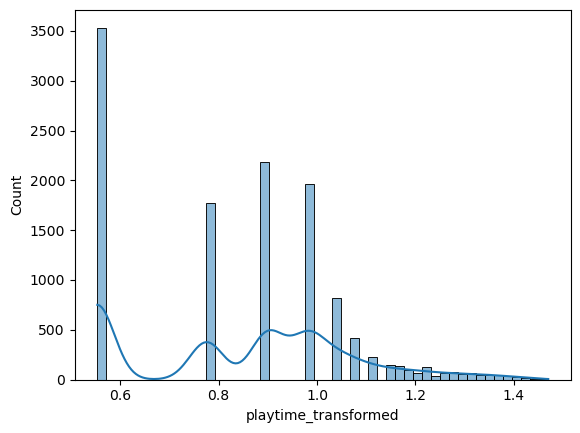

In [51]:
from scipy.stats import boxcox

# Ensure all values are positive
playtime = df['playtime'].astype(float) + 1  # add 1 if zeros exist

# Apply Box-Cox
df['playtime_transformed'], _ = boxcox(playtime)


# Check skewness
print("Original skew:", df['playtime'].skew())
print("Transformed skew:", df['playtime_transformed'].skew())
df = df.drop(columns=['playtime'])

sns.histplot(df['playtime_transformed'], bins=50, kde=True)
plt.show()


In [52]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

columns_to_encode = ["parent_platforms", "genres"]

for col in columns_to_encode:
    mlb = MultiLabelBinarizer()  # separate encoder for each column
    
    # Split multi-value strings into lists (e.g., "Action|RPG" → ["Action", "RPG"])
    df[col] = df[col].str.split('|')
    
    # Encode into one-hot DataFrame
    encoded = pd.DataFrame(
        mlb.fit_transform(df[col]),
        columns=[f"{col}_{c}" for c in mlb.classes_],
        index=df.index
    )
    
    # Concatenate encoded features and drop original column
    df = pd.concat([df.drop(columns=[col]), encoded], axis=1)


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12037 entries, 0 to 41791
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   name                                12037 non-null  object 
 1   rating                              12037 non-null  float64
 2   ratings_count                       12037 non-null  float64
 3   reviews_count                       12037 non-null  float64
 4   added                               12037 non-null  float64
 5   suggestions_count                   12037 non-null  float64
 6   background_image                    12037 non-null  object 
 7   released                            12037 non-null  object 
 8   playtime_transformed                12037 non-null  float64
 9   parent_platforms_                   12037 non-null  int32  
 10  parent_platforms_3DO                12037 non-null  int32  
 11  parent_platforms_Android            12037 non-

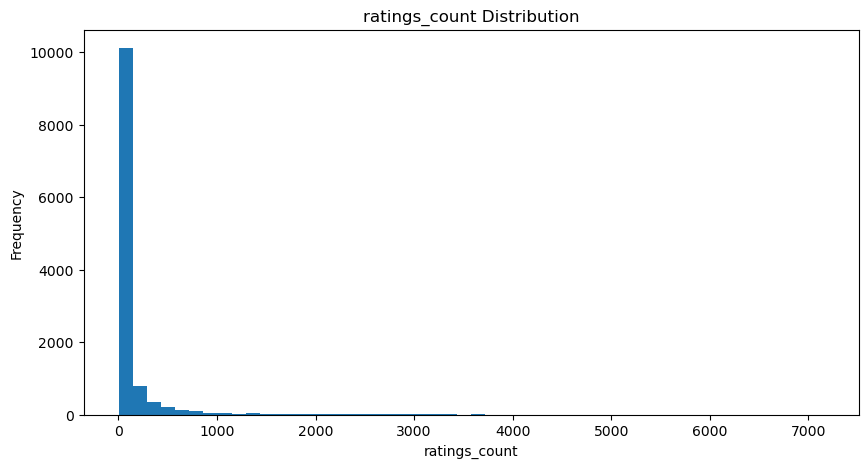

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df["ratings_count"].dropna(), bins=50)
plt.xlabel("ratings_count")
plt.ylabel("Frequency")
plt.title("ratings_count Distribution")
plt.show()


Original skew: 7.173995282299133
Transformed skew: 0.1721789379863495


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


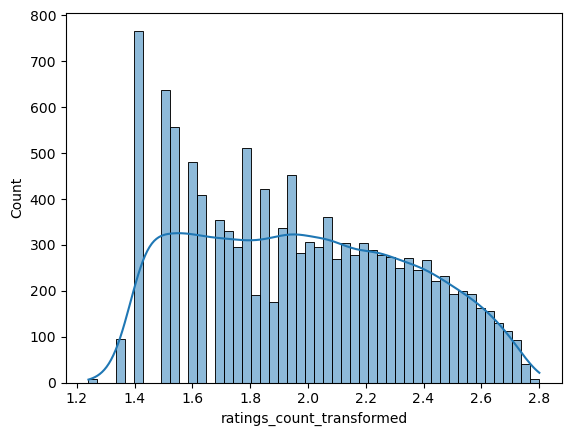

In [55]:
from scipy.stats import boxcox

# Ensure all values are positive
playtime = df['ratings_count'].astype(float) + 1  # add 1 if zeros exist

# Apply Box-Cox
df['ratings_count_transformed'], _ = boxcox(playtime)


# Check skewness
print("Original skew:", df['ratings_count'].skew())
print("Transformed skew:", df['ratings_count_transformed'].skew())
df = df.drop(columns=['ratings_count'])

sns.histplot(df['ratings_count_transformed'], bins=50, kde=True)
plt.show()


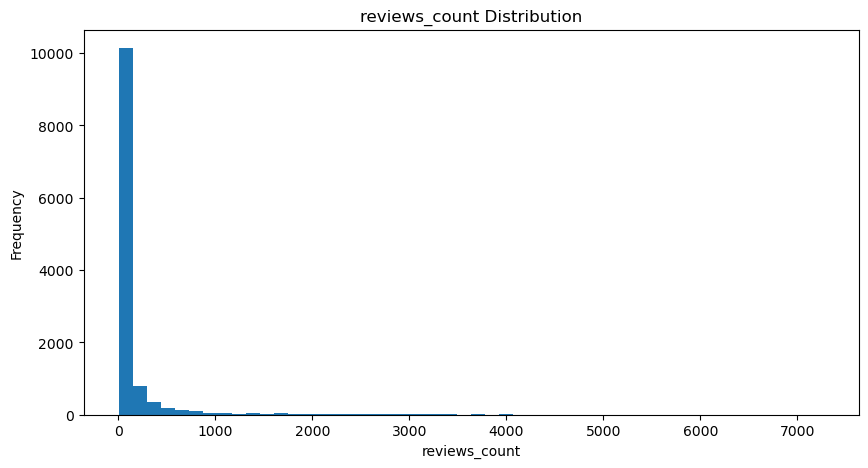

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df["reviews_count"].dropna(), bins=50)
plt.xlabel("reviews_count")
plt.ylabel("Frequency")
plt.title("reviews_count Distribution")
plt.show()


Original skew: 7.196600788243013
Transformed skew: 0.17530926397249855


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


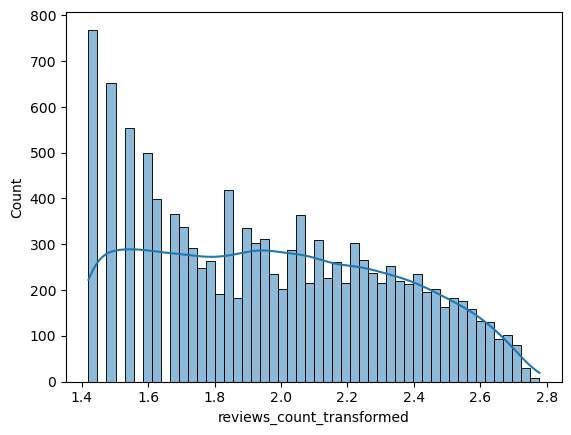

In [57]:
from scipy.stats import boxcox

# Ensure all values are positive
playtime = df['reviews_count'].astype(float) + 1  # add 1 if zeros exist

# Apply Box-Cox
df['reviews_count_transformed'], _ = boxcox(playtime)


# Check skewness
print("Original skew:", df['reviews_count'].skew())
print("Transformed skew:", df['reviews_count_transformed'].skew())
df = df.drop(columns=['reviews_count'])

sns.histplot(df['reviews_count_transformed'], bins=50, kde=True)
plt.show()


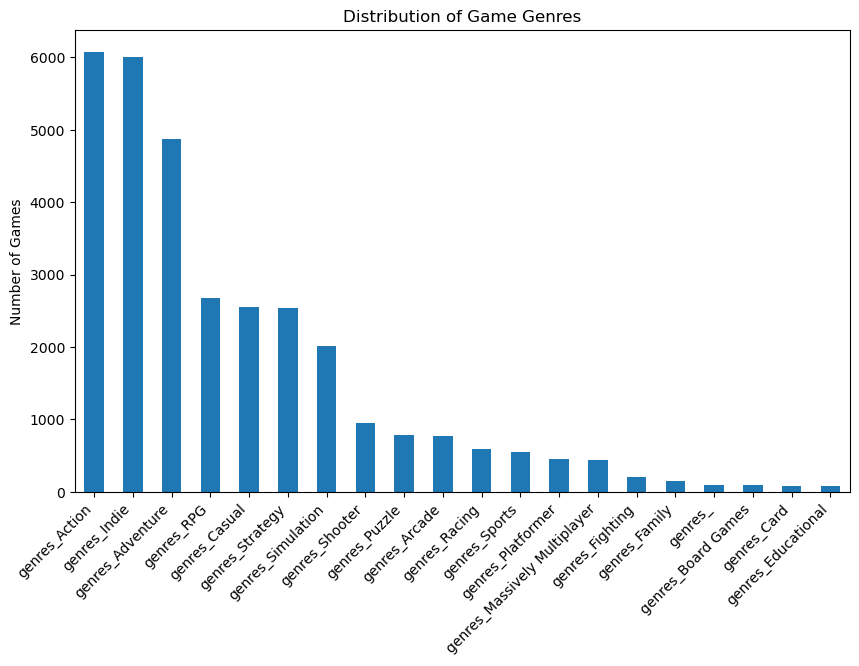

In [58]:
import matplotlib.pyplot as plt

# Sum each genre column (since 1 = presence)
genre_counts = df.filter(like="genres_").sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
genre_counts.plot(kind='bar')
plt.title("Distribution of Game Genres")
plt.ylabel("Number of Games")
plt.xticks(rotation=45, ha='right')
plt.show()


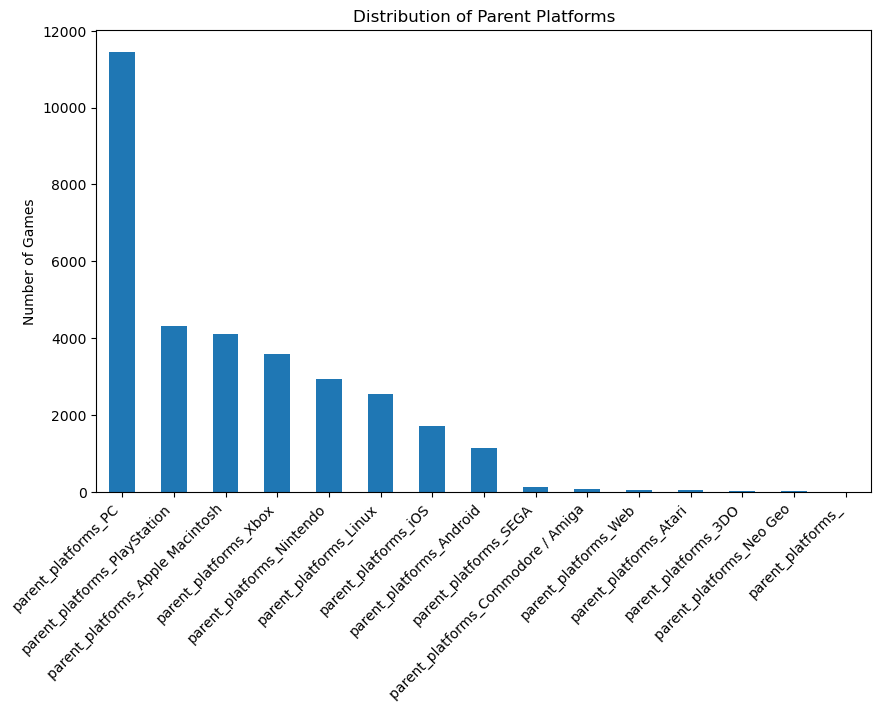

In [59]:
platform_counts = df.filter(like="parent_platforms_").sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
platform_counts.plot(kind='bar')
plt.title("Distribution of Parent Platforms")
plt.ylabel("Number of Games")
plt.xticks(rotation=45, ha='right')
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Game Ratings')

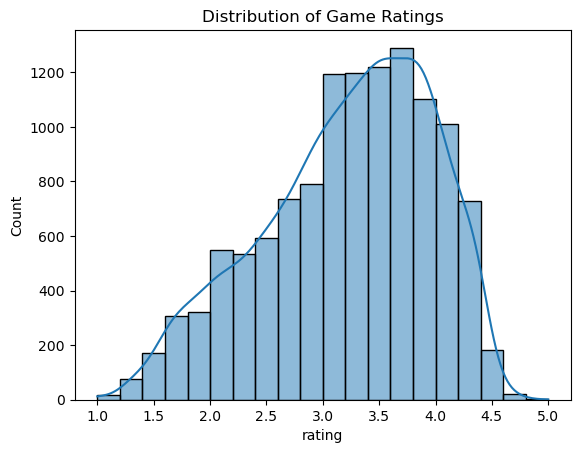

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribution of Game Ratings')


Text(0.5, 1.0, 'Ratings Count vs Average Rating')

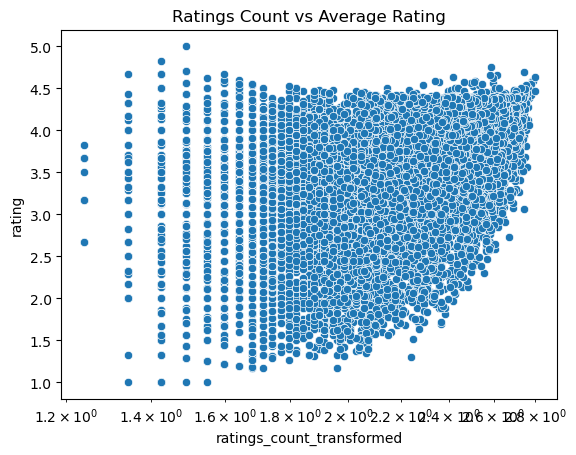

In [61]:
sns.scatterplot(data=df, x='ratings_count_transformed', y='rating')
plt.xscale('log')
plt.title('Ratings Count vs Average Rating')


<Axes: xlabel='reviews_count_transformed', ylabel='rating'>

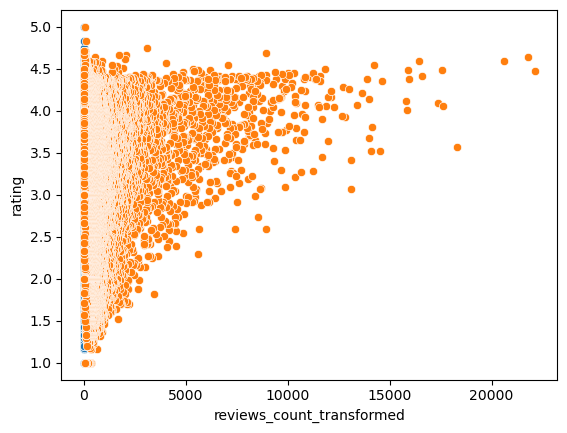

In [62]:
sns.scatterplot(data=df, x='reviews_count_transformed', y='rating')
sns.scatterplot(data=df, x='added', y='rating')


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


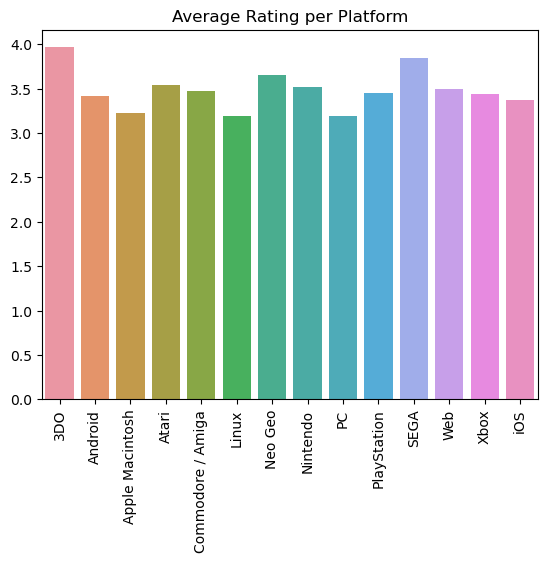

In [63]:
avg_rating = {
    col.replace('parent_platforms_', ''): df.loc[df[col] == 1, 'rating'].mean()
    for col in df.columns if col.startswith('parent_platforms_') and col != 'parent_platforms_'
}

sns.barplot(x=list(avg_rating.keys()), y=list(avg_rating.values()))
plt.xticks(rotation=90)
plt.title('Average Rating per Platform')
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Text(0.5, 1.0, 'Average Rating per Genre')

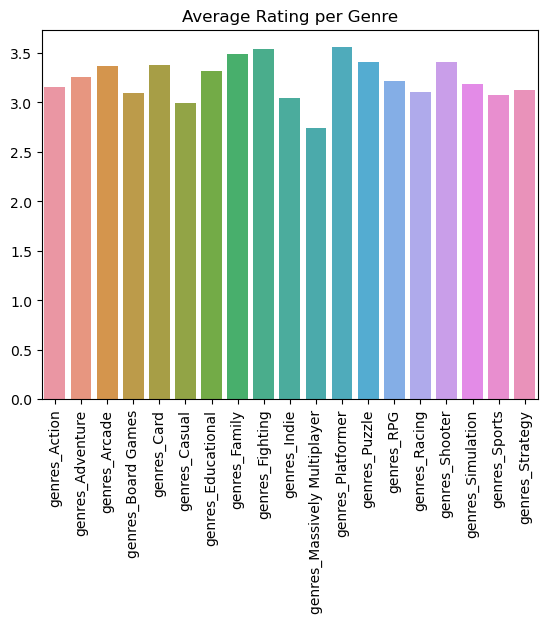

In [64]:
genre_cols = [col for col in df.columns if 'genres_' in col]
avg_rating_by_genre = {
    col: df.loc[df[col] == 1, 'rating'].mean()
    for col in genre_cols
    if col != 'genres_'
}
sns.barplot(x=list(avg_rating_by_genre.keys()), y=list(avg_rating_by_genre.values()))
plt.xticks(rotation=90)
plt.title('Average Rating per Genre')

Text(0.5, 1.0, 'Correlation Matrix of Numeric Features')

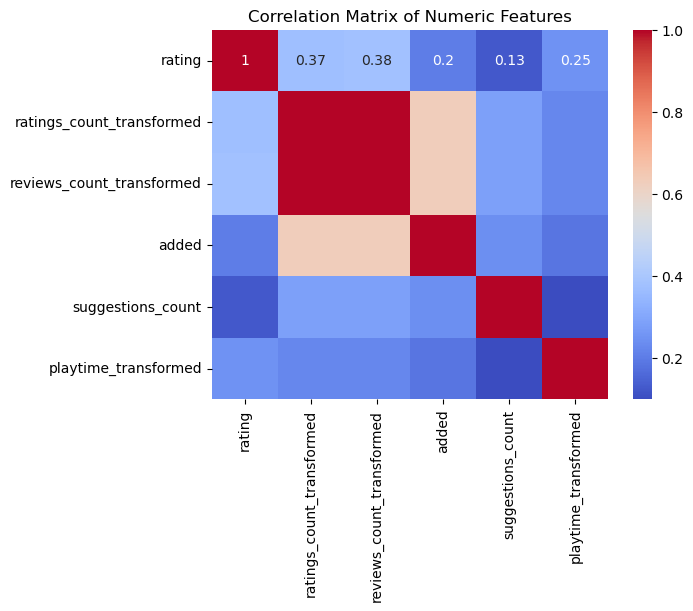

In [65]:
num_cols = ['rating', 'ratings_count_transformed', 'reviews_count_transformed', 'added', 
            'suggestions_count', 'playtime_transformed']
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')

In [66]:
corr_matrix = df.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df = df.drop(columns=to_drop)


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12037 entries, 0 to 41791
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   name                                12037 non-null  object 
 1   rating                              12037 non-null  float64
 2   added                               12037 non-null  float64
 3   suggestions_count                   12037 non-null  float64
 4   background_image                    12037 non-null  object 
 5   released                            12037 non-null  object 
 6   playtime_transformed                12037 non-null  float64
 7   parent_platforms_                   12037 non-null  int32  
 8   parent_platforms_3DO                12037 non-null  int32  
 9   parent_platforms_Android            12037 non-null  int32  
 10  parent_platforms_Apple Macintosh    12037 non-null  int32  
 11  parent_platforms_Atari              12037 non-

In [68]:
# 1️⃣ Identify platform and genre columns
platform_cols = [col for col in df.columns if 'parent_platforms_' in col]
genre_cols = [col for col in df.columns if 'genres_' in col and col != 'genres_']

# 2️⃣ Get top 10 games by rating
top_games = df.sort_values(by='rating', ascending=False).head(10)

# 3️⃣ Function to extract platform/genre names for each row
def get_labels(row, cols, prefix):
    labels = [col.replace(prefix, '') for col in cols if row[col] == 1]
    return ' | '.join(labels) if labels else 'None'

# 4️⃣ Create new columns with readable platform and genre names
top_games = top_games.copy()  # avoid SettingWithCopyWarning
top_games['Platforms'] = top_games.apply(lambda row: get_labels(row, platform_cols, 'parent_platforms_'), axis=1)
top_games['Genres'] = top_games.apply(lambda row: get_labels(row, genre_cols, 'genres_'), axis=1)

# 5️⃣ Display final table
print(top_games[['name', 'rating', 'Platforms', 'Genres']])


                                  name  rating  \
26151        Hazumi and the Pregnation    5.00   
16635            ATRI -My Dear Moments    4.83   
792                    Persona 5 Royal    4.75   
30005  Majesty: The Northern Expansion    4.71   
20409      Red Rope: Don't Fall Behind    4.71   
18531                      Micro Mages    4.71   
106          The Last Of Us Remastered    4.69   
22406             Drova - Forsaken Kin    4.67   
19145           ARK: Survival Ascended    4.67   
28870             Fallen Hero: Rebirth    4.67   

                                          Platforms  \
26151                                            PC   
16635                                            PC   
792              Nintendo | PC | PlayStation | Xbox   
30005                                            PC   
20409                  Apple Macintosh | Linux | PC   
18531                                 Nintendo | PC   
106                                     PlayStation   
22406    

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12037 entries, 0 to 41791
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   name                                12037 non-null  object 
 1   rating                              12037 non-null  float64
 2   added                               12037 non-null  float64
 3   suggestions_count                   12037 non-null  float64
 4   background_image                    12037 non-null  object 
 5   released                            12037 non-null  object 
 6   playtime_transformed                12037 non-null  float64
 7   parent_platforms_                   12037 non-null  int32  
 8   parent_platforms_3DO                12037 non-null  int32  
 9   parent_platforms_Android            12037 non-null  int32  
 10  parent_platforms_Apple Macintosh    12037 non-null  int32  
 11  parent_platforms_Atari              12037 non-

In [70]:
features = df.drop(columns=['name','background_image','released'], axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features.head(5)

rating      added  suggestions_count  playtime_transformed  \
0  0.307682   6.637162          -0.488505             -1.294628   
1  1.159556  10.163934           1.297415              1.430205   
2  1.691977  10.277342          -0.397792              0.602457   
3  0.946587   7.321930           1.484511              2.002641   
4  1.199487   9.171605           1.064962              1.052553   

   parent_platforms_  parent_platforms_3DO  parent_platforms_Android  \
0          -0.018232             -0.034124                 -0.323601   
1          -0.018232             -0.034124                 -0.323601   
2          -0.018232             -0.034124                  3.090229   
3          -0.018232             -0.034124                 -0.323601   
4          -0.018232             -0.034124                  3.090229   

   parent_platforms_Apple Macintosh  parent_platforms_Atari  \
0                          1.389293               -0.057014   
1                          1.389293               -0.057014   
2                          1.389293               -0.057014   
3                          1.389293               -0.057014   
4                          1.389293               -0.057014   

   parent_platforms_Commodore / Amiga  ...  genres_Massively Multiplayer  \
0                           -0.080761  ...                     -0.196158   
1                           -0.080761  ...                     -0.196158   
2                           -0.080761  ...                     -0.196158   
3                           -0.080761  ...                     -0.196158   
4                           -0.080761  ...                     -0.196158   

   genres_Platformer  genres_Puzzle  genres_RPG  genres_Racing  \
0          -0.199108      -0.265389   -0.535307      -0.228441   
1          -0.199108      -0.265389   -0.535307      -0.228441   
2          -0.199108       3.768054   -0.535307      -0.228441   
3          -0.199108      -0.265389   -0.535307       4.377497   
4          -0.199108      -0.265389   -0.535307      -0.228441   

   genres_Shooter  genres_Simulation  genres_Sports  genres_Strategy  \
0       -0.293891          -0.449063      -0.217980        -0.516126   
1        3.402624          -0.449063      -0.217980        -0.516126   
2       -0.293891          -0.449063      -0.217980        -0.516126   
3       -0.293891          -0.449063       4.587569        -0.516126   
4       -0.293891          -0.449063      -0.217980        -0.516126   

   ratings_count_transformed  
0                   1.892320  
1                   2.112298  
2                   2.173582  
3                   2.081841  
4                   2.129696  

[5 rows x 40 columns]

In [71]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute').fit(scaled_features)
print(model)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)


In [72]:
vg_distances, vg_indices = model.kneighbors(scaled_features)

print("List of indexes and distances for the first 5 games:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])

List of indexes and distances for the first 5 games:

[[  0  66  64 176 281  40 164 193 461 423  29]
 [  1  29  10  31   5  18  83  19  33  13  82]
 [  2  13  55   4  24  31  47  38  21  16   6]
 [  3 236 541 569  47 861 219 130  24  21  39]
 [  4  23  28 196  77  31   6  21   2 172 126]] 

[[0.00000000e+00 2.55166307e-03 2.78186428e-03 3.27963687e-02
  6.92285089e-02 9.13430038e-02 1.19680418e-01 1.29488026e-01
  1.32143310e-01 1.33275299e-01 1.37801539e-01]
 [0.00000000e+00 2.51339959e-02 2.75058774e-02 4.77208613e-02
  4.92102447e-02 5.22102131e-02 5.33409633e-02 5.67149904e-02
  6.70222926e-02 7.03023908e-02 7.69355930e-02]
 [2.22044605e-16 1.09620702e-01 1.31017722e-01 1.44976637e-01
  1.45507533e-01 1.49167103e-01 1.52284827e-01 1.53759152e-01
  1.53792061e-01 1.63509883e-01 1.66144957e-01]
 [1.11022302e-16 1.42344546e-01 2.21744728e-01 2.29153171e-01
  2.48611548e-01 2.51766014e-01 2.62963978e-01 2.72897796e-01
  2.76635503e-01 2.90522476e-01 2.99756443e-01]
 [0.00000000e+00 8.9

In [74]:
game_names = df['name'].drop_duplicates()
game_names = game_names.reset_index(drop=True)

vectorizer = TfidfVectorizer(use_idf=True).fit(game_names)
print(vectorizer)

TfidfVectorizer()


In [75]:
game_title_vectors = vectorizer.transform(game_names)

print("List of game title vectors for the first 5 games:\n")
print(pd.DataFrame(game_title_vectors.toarray()).head(5))

List of game title vectors for the first 5 games:

   0     1     2     3     4     5     6     7     8     9     ...  9331  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   9332  9333  9334  9335  9336  9337  9338  9339  9340  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 9341 columns]


In [76]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import difflib

def _build_similarity_index(df_source, n_neighbors=11, metric='cosine'):
    # feature selection
    numeric_cols = [c for c in ['rating','ratings_count_transformed','playtime_transformed','suggestions_count'] if c in df_source.columns]
    platform_cols = [c for c in df_source.columns if c.startswith('parent_platforms_')]
    genre_cols = [c for c in df_source.columns if c.startswith('genres_')]

    if not (numeric_cols or platform_cols or genre_cols):
        raise ValueError("No usable feature columns found in df to build similarity index.")

    # numeric features
    X_num = df_source[numeric_cols].fillna(0).values.astype(float) if numeric_cols else np.empty((len(df_source), 0))
    if numeric_cols:
        X_num = StandardScaler().fit_transform(X_num)

    # one-hot features
    X_oh_parts = []
    if platform_cols:
        X_oh_parts.append(df_source[platform_cols].fillna(0).values.astype(float))
    if genre_cols:
        X_oh_parts.append(df_source[genre_cols].fillna(0).values.astype(float))
    X_oh = np.hstack(X_oh_parts) if X_oh_parts else np.empty((len(df_source), 0))

    X = np.hstack([X_num, X_oh]) if X_num.size and X_oh.size else (X_num if X_num.size else X_oh)

    n_neighbors = min(n_neighbors, len(df_source))
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    return {
        'indices': indices,
        'distances': distances,
        'platform_cols': platform_cols,
        'genre_cols': genre_cols,
        'numeric_cols': numeric_cols
    }

def VideoGameTitleRecommender(title, df_local):
    choices = df_local['name'].astype(str).unique().tolist()
    matches = difflib.get_close_matches(title, choices, n=1, cutoff=0.5)
    return matches[0] if matches else None

def VideoGameRecommender(video_game_name, video_game_platform='Any', top_n=10):
    global df
    if 'df' not in globals():
        raise NameError("DataFrame 'df' not found. Load your dataset into variable 'df'.")

    platform_cols = [c for c in df.columns if c.startswith('parent_platforms_')]

    # filter DF to the platform first (this is the important fix)
    filtered_df = df.copy()
    platform_column = None
    if video_game_platform != 'Any':
        platform_column = f'parent_platforms_{video_game_platform}'
        if platform_column in df.columns:
            filtered_df = filtered_df[filtered_df[platform_column] == 1]
            if filtered_df.empty:
                print(f"No games found on platform '{video_game_platform}'.")
                return
        else:
            print(f"Platform '{video_game_platform}' not found in dataset.")
            return

    # find the requested game in filtered df
    candidate_rows = filtered_df[filtered_df['name'].astype(str) == str(video_game_name)]
    if candidate_rows.empty:
        # fallback: suggest closest match on platform
        suggestion = VideoGameTitleRecommender(video_game_name, filtered_df)
        if suggestion:
            print(f"'{video_game_name}' not found on this platform. Did you mean '{suggestion}'?")
        else:
            print(f"No match found for '{video_game_name}' on platform '{video_game_platform}'.")
        return

    # build index from platform-filtered DF
    index_data = _build_similarity_index(filtered_df, n_neighbors=min(11, len(filtered_df)))

    # find neighbors of the first match
    target_idx = candidate_rows.index[0]
    pos_in_filtered = filtered_df.index.get_loc(target_idx)

    neighbors = index_data['indices'][pos_in_filtered][1: top_n+1]
    recs = filtered_df.iloc[neighbors].copy()

    # Platforms & Genres display
    if platform_cols:
        recs['Platforms'] = recs[platform_cols].apply(
            lambda row: ' | '.join([c.replace('parent_platforms_', '') for c in platform_cols if row[c] == 1]),
            axis=1
        )
    else:
        recs['Platforms'] = ''

    genre_cols = [c for c in df.columns if c.startswith('genres_')]
    if genre_cols:
        recs['Genres'] = recs[genre_cols].apply(
            lambda row: ' | '.join([c.replace('genres_', '') for c in genre_cols if row[c] == 1]),
            axis=1
        )
    else:
        recs['Genres'] = ''

    # columns to display
    cols = ['name','rating']
    if 'ratings_count_transformed' in recs.columns:
        cols.append('ratings_count_transformed')
    elif 'ratings_count' in recs.columns:
        cols.append('ratings_count')
    cols += ['Platforms','Genres']

    print(f"Top {len(recs)} Recommended Games for '{video_game_name}' on {video_game_platform}")
    display(recs[cols].reset_index(drop=True))


In [53]:
# Evaluation code for your item-based KNN recommender (no user interactions required)
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from math import log2

# -------------------------
# Helpers: feature matrix
# -------------------------
def build_feature_matrix(df, numeric_cols=None, platform_prefix='parent_platforms_', genre_prefix='genres_'):
    # choose sensible defaults if None
    if numeric_cols is None:
        numeric_cols = [c for c in ['rating','ratings_count_transformed','playtime_transformed','suggestions_count'] if c in df.columns]
    platform_cols = [c for c in df.columns if c.startswith(platform_prefix)]
    genre_cols = [c for c in df.columns if c.startswith(genre_prefix)]

    # numeric
    if numeric_cols:
        X_num = df[numeric_cols].fillna(0).astype(float).values
        X_num = StandardScaler().fit_transform(X_num)
    else:
        X_num = np.empty((len(df), 0))

    # one-hot
    parts = []
    if platform_cols:
        parts.append(df[platform_cols].fillna(0).astype(float).values)
    if genre_cols:
        parts.append(df[genre_cols].fillna(0).astype(float).values)

    X_oh = np.hstack(parts) if parts else np.empty((len(df), 0))

    if X_num.size and X_oh.size:
        X = np.hstack([X_num, X_oh])
    elif X_num.size:
        X = X_num
    else:
        X = X_oh

    meta = {
        'platform_cols': platform_cols,
        'genre_cols': genre_cols,
        'numeric_cols': numeric_cols
    }
    return X, meta

# -------------------------
# Ranking metrics
# -------------------------
def precision_at_k(recommended, relevant_set, k):
    if k <= 0:
        return 0.0
    hits = sum(1 for r in recommended[:k] if r in relevant_set)
    return hits / k

def recall_at_k(recommended, relevant_set, k):
    if not relevant_set:
        return 0.0
    hits = sum(1 for r in recommended[:k] if r in relevant_set)
    return hits / len(relevant_set)

def average_precision_at_k(recommended, relevant_set, k):
    ap = 0.0
    hits = 0
    for i, r in enumerate(recommended[:k], start=1):
        if r in relevant_set:
            hits += 1
            ap += hits / i
    return (ap / min(len(relevant_set), k)) if relevant_set else 0.0

def dcg_at_k(recommended, relevant_set, k):
    dcg = 0.0
    for i, r in enumerate(recommended[:k], start=1):
        rel = 1 if r in relevant_set else 0
        dcg += (2**rel - 1) / log2(i + 1)
    return dcg

def idcg_at_k(relevant_set, k):
    # ideal DCG: all relevant items at top positions
    ideal_rels = [1] * min(len(relevant_set), k)
    idcg = sum((2**r - 1) / log2(i + 1) for i, r in enumerate(ideal_rels, start=1))
    return idcg

def ndcg_at_k(recommended, relevant_set, k):
    idcg = idcg_at_k(relevant_set, k)
    if idcg == 0:
        return 0.0
    return dcg_at_k(recommended, relevant_set, k) / idcg

# -------------------------
# Build KNN and recommendations
# -------------------------
def build_knn_and_recommend(X, n_neighbors=11, metric='cosine', n_jobs=-1):
    n_neighbors = min(n_neighbors, len(X))
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=n_jobs)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)
    return distances, indices

# -------------------------
# Define relevance: share genre (can customize)
# -------------------------
def build_genre_sets(df, genre_cols):
    # for each index return set of genre names where flag == 1
    def genres_of_row(row):
        return set(col.replace('genres_', '') for col in genre_cols if int(row[col]) == 1)
    return [genres_of_row(row) for _, row in df.iterrows()]

# -------------------------
# Full evaluation pipeline
# -------------------------
def evaluate_item_knn(df, k=10, metric='cosine', relevance='genre', require_shared_platform=False):
    """
    relevance: 'genre' (default) or 'platform' or 'genre+platform'
    require_shared_platform: if True, recommendations will be filtered to same platform BEFORE evaluation pool (optional)
    """
    X, meta = build_feature_matrix(df)
    distances, indices = build_knn_and_recommend(X, n_neighbors=k+1, metric=metric)
    platform_cols = meta['platform_cols']
    genre_cols = meta['genre_cols']

    # Prepare relevance sets
    if relevance in ('genre','genre+platform'):
        genre_sets = build_genre_sets(df, genre_cols)
    else:
        genre_sets = [set() for _ in range(len(df))]

    # platform sets
    def platforms_of_row(row):
        return set(col.replace('parent_platforms_', '') for col in platform_cols if int(row[col]) == 1)
    platform_sets = [platforms_of_row(row) for _, row in df.iterrows()]

    precisions, recalls, apks, ndcgs = [], [], [], []
    same_platform_counts = []  # % of recs that are on same platform
    n = len(df)

    for i in range(n):
        # recommended indices for item i (exclude itself at position 0)
        recs = [int(idx) for idx in indices[i][1:k+1]]
        # Build relevant set based on chosen rule
        relevant = set()
        if relevance == 'genre':
            # relevant if share >=1 genre
            base_genres = genre_sets[i]
            relevant = {j for j in range(n) if j != i and base_genres & genre_sets[j]}
        elif relevance == 'platform':
            base_plats = platform_sets[i]
            relevant = {j for j in range(n) if j != i and base_plats & platform_sets[j]}
        elif relevance == 'genre+platform':
            base_genres = genre_sets[i]
            base_plats = platform_sets[i]
            relevant = {j for j in range(n) if j != i and (base_genres & genre_sets[j]) and (base_plats & platform_sets[j])}
        else:
            raise ValueError("Unsupported relevance setting")

        # Optional: if require_shared_platform True, limit candidate universe to same-platform items when computing relevant
        if require_shared_platform:
            same_platform_universe = {j for j in range(n) if platform_sets[i] & platform_sets[j]}
            relevant = relevant & same_platform_universe

        precisions.append(precision_at_k(recs, relevant, k))
        recalls.append(recall_at_k(recs, relevant, k))
        apks.append(average_precision_at_k(recs, relevant, k))
        ndcgs.append(ndcg_at_k(recs, relevant, k))

        # platform agreement: percentage of recommended items sharing any platform with item i
        num_same_platform = sum(1 for r in recs if platform_sets[i] & platform_sets[r])
        same_platform_counts.append(num_same_platform / k)

    results = {
        'Precision@K': np.mean(precisions),
        'Recall@K': np.mean(recalls),
        'MAP@K': np.mean(apks),
        'NDCG@K': np.mean(ndcgs),
        'Avg_same_platform_ratio': np.mean(same_platform_counts)
    }
    return results

# -------------------------
# Example usage
# -------------------------
# k = 10
# res = evaluate_item_knn(df, k=10, metric='cosine', relevance='genre')
# print(res)


In [55]:
k = 11
res = evaluate_item_knn(df, k=11, metric='cosine', relevance='genre')
print(res)

{'Precision@K': 0.9822368324070936, 'Recall@K': 0.0026853697696638964, 'MAP@K': 0.9788064127318518, 'NDCG@K': 0.9850980104415219, 'Avg_same_platform_ratio': 0.9958134941108834}


In [78]:
import joblib
import pandas as pd

# The dataframe 'df' should be the one after all your cleaning and processing
# The 'model' should be your trained NearestNeighbors model

# Save the processed dataframe
df.to_pickle("processed_df.pkl")

# Save the k-NN model
joblib.dump(model, "knn_model.joblib")

['knn_model.joblib']